In [1]:
from pathlib import Path # for simplify creation of model paths

# import necessary essential libraries for utilizing PyTorch
import time
import numpy as np
import torch
from torch import nn

# import torch vision libraries for data loading and transformations
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, RandomRotation

from torch.utils.data import DataLoader

# import matplotlib for plot making
import matplotlib.pyplot as plt

# import tqdm for visualizing the progress bar for training
from tqdm.notebook import tqdm

# import clear_output for clear out the outputs sometimes for better presentation
from IPython.display import clear_output

# from sklearn import relevant packages to build visualized confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# version sanity check
print(torch.__version__)
print(torchvision.__version__)

2.0.0.dev20230125
0.15.0.dev20230125


In [2]:
# pre-creation of the directory for preserving models:
model_path=Path('models') # creation of the models dir path
model_path.mkdir(parents=True, exist_ok=True) # making the dir

model_name='chapter3_pytorch_computer_vision_exercise_model.pth' # name the model as
model_save_path=model_path/model_name # prepare the final dir for saving model

In [3]:
# we are composing transformations including ToTensor and RandomRotation for variations
composed_transformation=transforms.Compose([
    RandomRotation(90),
    ToTensor(),
])
train_data=datasets.MNIST(
    'data',
    train=True,
    download=True,
    transform=composed_transformation
) # loading MNIST data for training

test_data=datasets.MNIST(
    'data',
    train=False,
    download=True,
    transform=ToTensor(),
) # loading MNIST data for testing
clear_output() # clear out current data loading display

In [4]:
class_to_idx=train_data.class_to_idx # preserve the class to index mapping to a variable
idx_to_class={v:k for k,v in train_data.class_to_idx.items()} # create a reversed idx to class mapping

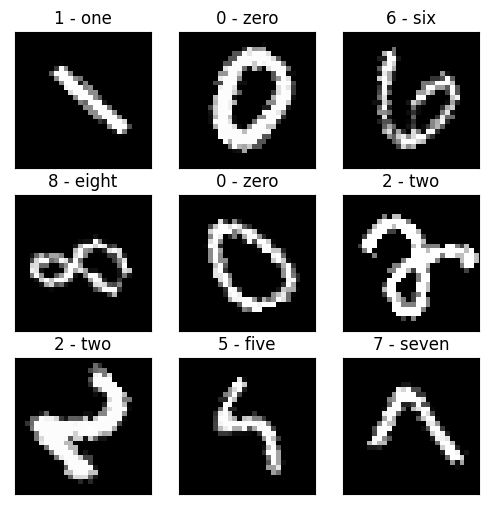

In [5]:
# randomly select 3 x 3 images from training data for visualization
plt.figure(figsize=(6,6))
for i in range(3*3):
    img_idx=np.random.choice(len(train_data),1)[0] # randomly picking out an image
    img, label=train_data[img_idx] # getting its pixelated tensor and label
    plt.subplot(3,3,i+1)
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.title(idx_to_class[label]) # show what does the image correspond to
    plt.xticks([])
    plt.yticks([])

In [6]:
# create data loaders for both train and test datasets
train_dataloader=DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=8, shuffle=False)

In [7]:
# establish framework for miniVGG
class miniVGG(nn.Module):
    def __init__(self, output_size=None): # using a downsampled structure of VGG
        super().__init__()
        self.ConvLayers=nn.Sequential(
            nn.Conv2d(1,16,2),
            nn.ReLU(),
            nn.Conv2d(16,32,2),
            nn.ReLU(),
            nn.Conv2d(32,64,2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.LinearLayers=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*12*12,4096),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(4096,1000),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(1000,output_size)
        )
    
    def forward(self, x):
        o1=self.ConvLayers(x)
        o2=self.LinearLayers(o1)
        return o2

# create the model and set it up on M2 chip
model=miniVGG(10).to('mps')

# function to get an averaged pooled f1 score
def f1_score(y_true, y_pred):
    # macro averaging adopted
    f1_scores=[]
    for label in range(len(idx_to_class)):
        # list out components for calculating tp, fp, and fn situations
        true_mask=y_true==label
        false_mask=y_true!=label
        positive_mask=y_pred==label
        negative_mask=y_pred!=label

        # calculating tp, fp, and fn
        tp=(true_mask & positive_mask).sum().item()
        fp=(false_mask & positive_mask).sum().item()
        fn=(true_mask & negative_mask).sum().item()

        # get precision, recall, and f1
        # added 1e-6 to avoid situation of division by zero
        precision=tp/(tp+fp+1e-6)
        recall=tp/(tp+fn+1e-6)
        f1=2*precision*recall/(precision+recall+1e-6)
        f1_scores.append(f1)
    return np.mean(f1_scores) # return macro averaged f1 scores acquired from each class

# loss function and optimizer:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
# function for train and predict
def train_and_infer(device='mps', type='train'):
    if type=='train':
        train_loss=0 # refresh current training loss
        model.train() # set model to training mode
        for batch, (X,y) in enumerate(train_dataloader):
            _X, _y=X.to(device), y.to(device)
            y_pred=model(_X)
            loss=loss_fn(y_pred, _y)
            train_loss+=loss
            optimizer.zero_grad() # empty the gradient on optimizer
            loss.backward() # back propagation of loss
            optimizer.step()
        train_loss/=len(train_dataloader)
        print(f'train loss: {train_loss:.3f}')

    elif type=='infer':
        test_loss, test_score=0,0
        model.eval()
        with torch.inference_mode(): # set model to evaluation and inference mode
            y_tests, y_test_preds=[], []
            for X_test, y_test in test_dataloader:
                _X_test, _y_test=X_test.to(device), y_test.to(device)
                test_pred=model(_X_test)
                test_loss+=loss_fn(test_pred, _y_test)
                y_tests+=list(_y_test.to('cpu').numpy()) # preserve actual vs. pred labels
                y_test_preds+=list(test_pred.to('cpu').argmax(1).numpy())
            test_loss/=len(test_dataloader) # averaging loss and scoring for displaying single values
            test_score=f1_score(np.array(y_tests), np.array(y_test_preds))
        print(f'test loss: {test_loss:.3f} | test score: {test_score:.3f}')

In [9]:
epochs=32 # setting epoch to 32 for training
for epoch in tqdm(range(epochs)):
    start_time=time.time()
    print(f'Epoch: {epoch+1}\n-----')
    train_and_infer(type='train')
    train_and_infer(type='infer')
    print(f'Run time: {time.time()-start_time:.2f} s')
    print()

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1
-----
train loss: 2.239
test loss: 1.602 | test score: 0.541
Run time: 182.18 s

Epoch: 2
-----
train loss: 0.891
test loss: 0.436 | test score: 0.861
Run time: 185.96 s

Epoch: 3
-----
train loss: 0.432
test loss: 0.297 | test score: 0.906
Run time: 188.79 s

Epoch: 4
-----
train loss: 0.319
test loss: 0.232 | test score: 0.926
Run time: 203.58 s

Epoch: 5
-----
train loss: 0.270
test loss: 0.197 | test score: 0.938
Run time: 184.88 s

Epoch: 6
-----
train loss: 0.236
test loss: 0.177 | test score: 0.942
Run time: 192.03 s

Epoch: 7
-----
train loss: 0.215
test loss: 0.159 | test score: 0.949
Run time: 197.59 s

Epoch: 8
-----
train loss: 0.196
test loss: 0.153 | test score: 0.950
Run time: 198.50 s

Epoch: 9
-----
train loss: 0.183
test loss: 0.140 | test score: 0.954
Run time: 199.96 s

Epoch: 10
-----
train loss: 0.177
test loss: 0.128 | test score: 0.959
Run time: 192.73 s

Epoch: 11
-----
train loss: 0.163
test loss: 0.120 | test score: 0.961
Run time: 190.86 s

Epoch: 1

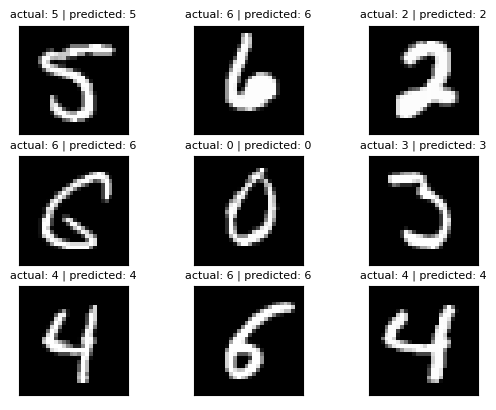

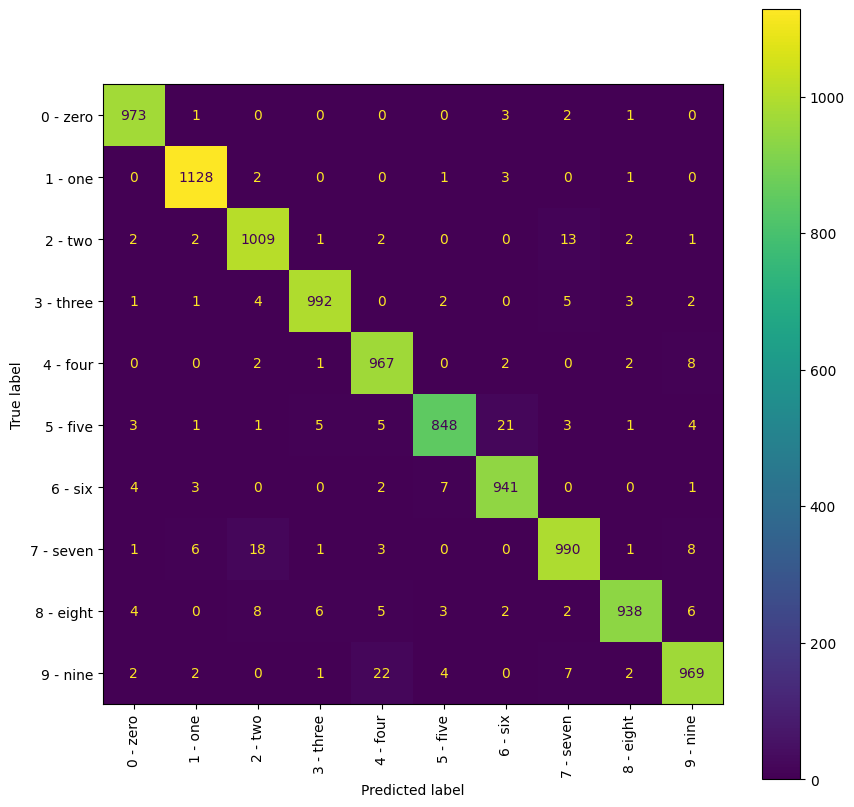

In [37]:
# create visualization of random prediction and confusion matrix
def randomPredictions():
    model.eval()
    labels=np.random.choice(len(test_data),9, replace=False)
    for idx, _label in enumerate(labels):
        image, label=test_data[_label]
        with torch.inference_mode():
            predicted_label=model(image.reshape([1,1,28,28]).to('mps')).to('cpu').argmax().item()
        title_content=f"actual: {label} | predicted: {predicted_label}"
        
        plt.subplot(3,3,idx+1)
        plt.imshow(image.reshape([28,28]),cmap='gray')
        plt.title(title_content, fontsize=8)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    return
randomPredictions()

def confusionMatrix(dataloader):
    true_labels, pred_labels=[], [] # initialize labels ffor comparison
    for x,y in dataloader:
        true_labels+=list(y.to('cpu').numpy())
        pred_labels+=list(model(x.to('mps')).to('cpu').argmax(1).numpy())
    # creating confusion matrix for display
    cm=confusion_matrix(true_labels, pred_labels)

    # asethetic params:
    disp=ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, display_labels=list(idx_to_class.values()))
    fig=disp.figure_
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.xticks(rotation=90)
    plt.show()
confusionMatrix(test_dataloader)